# WNTR Earthquake Demo

#### Import Python packages, including WNTR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.stats import expon
import wntr

np.random.seed(12345)

#### Create a water network model and define earthquake characteristics

In [2]:
inp_file = '../networks/Net3.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn = wntr.morph.scale_node_coordinates(wn,1000)
epicenter = (32000,15000) # x,y location
magnitude = 6.5 # Richter scale
depth = 10000 # m, shallow depth

#### Plot location of epicenter on the network

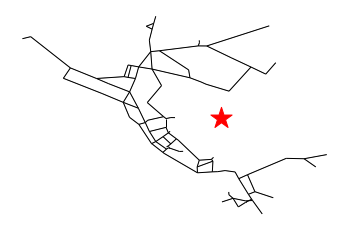

In [3]:
wntr.graphics.plot_network(wn, node_size=0)
plt.scatter(epicenter[0], epicenter[1], s=500, c='r', marker='*', zorder=2)

#### Generate the earthquake scenario

Min, Max, Average PGA: 0.14, 0.27, 0.22 g
Min, Max, Average PGV: 0.21, 0.63, 0.43 m/s
Min, Max, Average repair rate: 5e-05, 0.00015, 0.0001 per m
Min, Max, Average repair rate*pipe length: 2e-05, 1.00628, 0.05147
Number of pipe failures: 14


<Figure size 432x288 with 0 Axes>

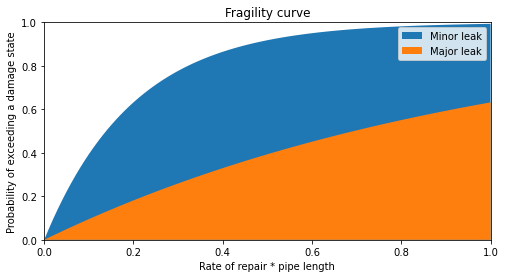

In [4]:
#This scenario assumes uniform pipe and soil type throughout the network.  These parameters can be set for individual pipes
#PGA = 0.001 g (0.01 m/s2) – perceptible by people
#PGA = 0.02  g (0.2  m/s2) – people lose their balance
#PGA = 0.50  g (5 m/s2) – very high; well-designed buildings can survive if the duration is short
#Repair rate of 1/km (0.001/m) has been suggested as an upper bound

earthquake = wntr.scenario.Earthquake(epicenter, magnitude, depth)

R = earthquake.distance_to_epicenter(wn, element_type=wntr.network.Pipe)
pga = earthquake.pga_attenuation_model(R)  
pgv = earthquake.pgv_attenuation_model(R)
RR = earthquake.repair_rate_model(pgv)
L = pd.Series(wn.query_link_attribute('length', link_type = wntr.network.Pipe))
    
pipe_FC = wntr.scenario.FragilityCurve()
pipe_FC.add_state('Minor leak', 1, {'Default': expon(scale=0.2)})
pipe_FC.add_state('Major leak', 2, {'Default': expon()})

plt.figure()
wntr.graphics.plot_fragility_curve(pipe_FC, xlabel='Rate of repair * pipe length')

pipe_Pr = pipe_FC.cdf_probability(RR*L)
pipe_damage_state = pipe_FC.sample_damage_state(pipe_Pr)

pipe_damage_state_map = pipe_FC.get_priority_map()
pipe_damage_val = pipe_damage_state.map(pipe_damage_state_map)

print("Min, Max, Average PGA: " + str(np.round(pga.min(),2)) + ", " + str(np.round(pga.max(),2)) + ", " + str(np.round(pga.mean(),2)) + " g")
print("Min, Max, Average PGV: " + str(np.round(pgv.min(),2)) + ", " + str(np.round(pgv.max(),2)) + ", " + str(np.round(pgv.mean(),2)) + " m/s")
print("Min, Max, Average repair rate: " + str(np.round(RR.min(),5)) + ", " + str(np.round(RR.max(),5)) + ", " + str(np.round(RR.mean(),5)) + " per m")
print("Min, Max, Average repair rate*pipe length: " + str(np.round((RR*L).min(),5)) + ", " + str(np.round((RR*L).max(),5)) + ", " + str(np.round((RR*L).mean(),5)))
print("Number of pipe failures: " + str(sum(pipe_damage_val > 0)))

#### Plot distance to the epicenter, peak ground acceleration, and peak ground velocity

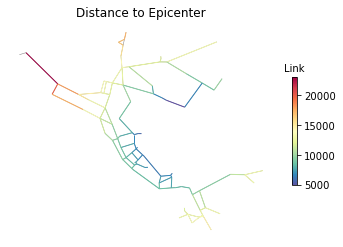

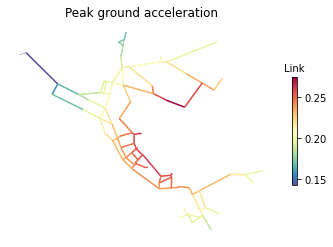

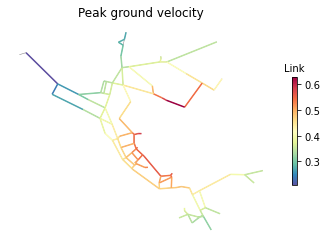

In [5]:
wntr.graphics.plot_network(wn, link_attribute=R, node_size=0, title='Distance to Epicenter')

wntr.graphics.plot_network(wn, link_attribute=pga, node_size=0, link_width=1.5, title='Peak ground acceleration')

wntr.graphics.plot_network(wn, link_attribute=pgv, node_size=0, link_width=1.5, title='Peak ground velocity')

#### Plot repair rate (# of repairs needed per m) and repair rate * pipe length

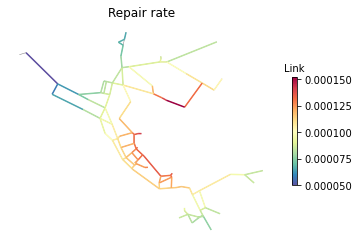

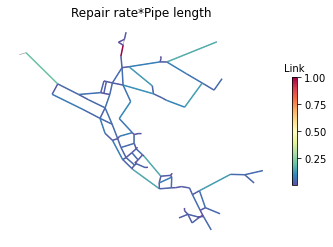

In [6]:
wntr.graphics.plot_network(wn, link_attribute=RR, node_size=0, link_width=1.5, title='Repair rate')

wntr.graphics.plot_network(wn, link_attribute=(RR*L), node_size=0, link_width=1.5, title='Repair rate*Pipe length')

#### Plot probability of leaks and damage state

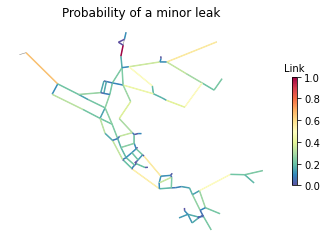

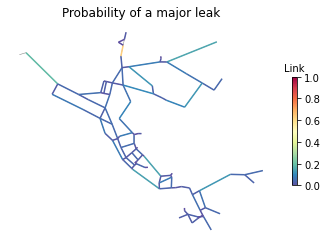

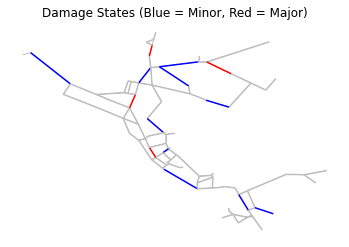

In [7]:
wntr.graphics.plot_network(wn, link_attribute=pipe_Pr['Minor leak'], node_size=0, link_range=[0,1], link_width=1.5, title='Probability of a minor leak')

wntr.graphics.plot_network(wn, link_attribute=pipe_Pr['Major leak'], node_size=0, link_range=[0,1], link_width=1.5, title='Probability of a major leak')

gray_red_colormap = wntr.graphics.custom_colormap(3, colors = ['0.75','blue','red'])
wntr.graphics.plot_network(wn, link_attribute=pipe_damage_val, node_size=0, link_width=1.5, link_cmap=gray_red_colormap, title='Damage States (Blue = Minor, Red = Major)', add_colorbar=False)

#### Simulate hydraulics without repair

In [8]:
# The simulation uses pressure driven hydraulics and leak models to account for loss.
#for name, node in wn.nodes():
#    node.required_pressure = 15
wn.options.time.duration = 24*3600
wn.options.time.hydraulic_timestep = 3600
wn.options.time.report_timestep = 3600
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 15

leak_start_time = 5*3600 # time of failure

for pipe_name, damage_state in pipe_damage_state.iteritems():
    pipe_diameter = wn.get_link(pipe_name).diameter
    if damage_state is not None:
        # Select leak diameter, uniform dist
        if damage_state == 'Major leak':
            leak_diameter = np.round(np.random.uniform(0.15,0.3*pipe_diameter,1), 2)[0]
            leak_diameter = np.amin([leak_diameter,0.15])
            leak_area = 3.14159/4.0*leak_diameter**2
        elif damage_state == 'Minor leak':
            leak_diameter = np.round(np.random.uniform(0,0.15*pipe_diameter,1), 2)[0]
            leak_diameter = np.amin([leak_diameter,0.15])
            leak_area = 3.14159/4.0*leak_diameter**2
        else:
            leak_area = 0
        # Add pipe leak to the network
        wn = wntr.morph.split_pipe(wn,pipe_name,pipe_name+'A','Leak'+pipe_name)
        n = wn.get_node('Leak'+pipe_name)
        n.add_leak(wn, area=leak_area, start_time=leak_start_time)
    
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

#### Identify highest leaks for repair¶

Leak329    7.703545
Leak119    3.917405
Leak215    3.485491
Leak145    1.786605
dtype: float64


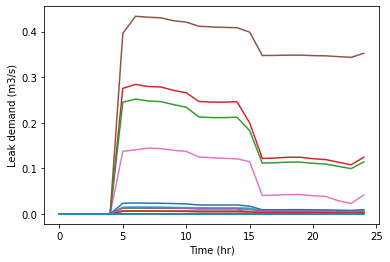

In [9]:
# Rank leaked demand
leaked_demand = results.node['leak_demand']
leaked_sum = leaked_demand.sum()
leaked_sum.sort_values(ascending=False, inplace=True)

# Plot leak demand
leaked_demand.index = leaked_demand.index/3600
ax=leaked_demand.plot(legend=False)
ax.set_ylabel('Leak demand (m3/s)')
ax.set_xlabel('Time (hr)')

# Select top pipes to fix
number_of_pipes_to_repair = 4
pipes_to_fix = leaked_sum[0:number_of_pipes_to_repair]
print(pipes_to_fix)

#### Simulate hydraulics with repair

In [10]:
wn.reset_initial_values()

duration_of_failure = 10*3600
leak_repair_time = leak_start_time+duration_of_failure

for leak_name in pipes_to_fix.index:
    node = wn.get_node(leak_name)
    leak_area = node.leak_area
    node.remove_leak(wn)
    node.add_leak(wn, area=leak_area, start_time=leak_start_time, end_time=leak_repair_time)

results_wrepair = sim.run_sim()

## Compare results
#### Node Pressure

Text(0.5, 1.0, 'With repair')

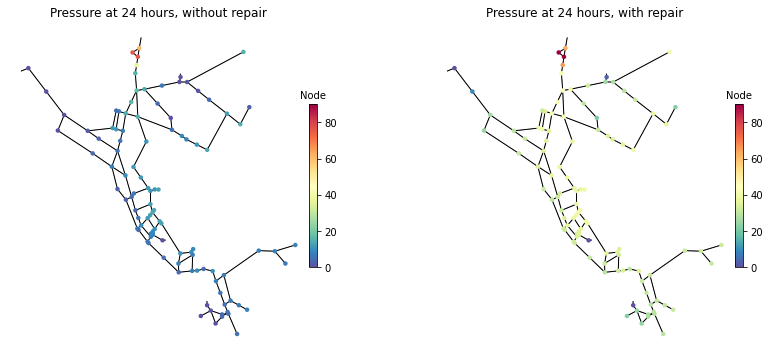

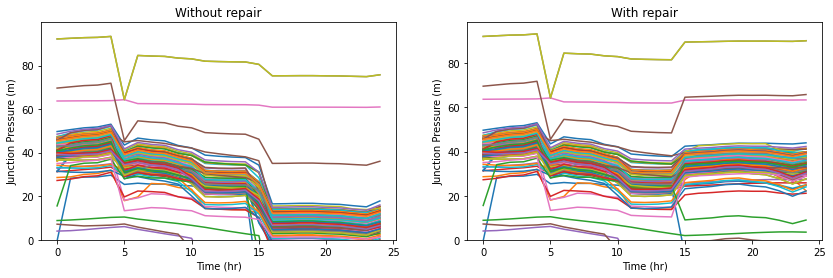

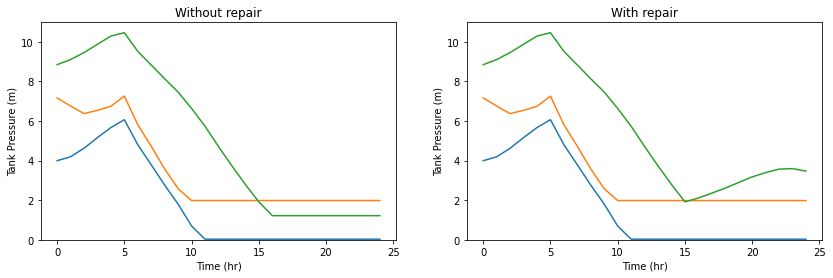

In [12]:
pressure = results.node['pressure']
pressure_wrepair = results_wrepair.node['pressure']
pressure.index = pressure.index/3600
pressure_wrepair.index = pressure_wrepair.index/3600

# Junction pressure, network plot
fig, axarr = plt.subplots(1,2,figsize=(14,6))
ax = axarr[0]
pressure_at_24hr = pressure.loc[24,wn.junction_name_list]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_24hr, node_size=20, node_range = [0,90], title='Pressure at 24 hours, without repair', ax=ax)
ax = axarr[1]
pressure_at_24hr = pressure_wrepair.loc[24,wn.junction_name_list]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_24hr, node_size=20, node_range = [0,90], title='Pressure at 24 hours, with repair', ax=ax)

# Junction pressure, timeseries
fig, axarr = plt.subplots(1,2,figsize=(14,4))
ax = axarr[0]
pressure.loc[:,wn.junction_name_list].plot(ax=ax, legend=False)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Junction Pressure (m)')
ax.set_title('Without repair')
ax = axarr[1]
pressure_wrepair.loc[:,wn.junction_name_list].plot(ax=ax, legend=False)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Junction Pressure (m)')
ax.set_title('With repair')

# Tank pressure, timeseries
fig, axarr = plt.subplots(1,2,figsize=(14,4))
ax = axarr[0]
pressure.loc[:,wn.tank_name_list].plot(ax=ax, legend=False)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Tank Pressure (m)')
ax.set_title('Without repair')
ax = axarr[1]
pressure_wrepair.loc[:,wn.tank_name_list].plot(ax=ax, legend=False)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Tank Pressure (m)')
ax.set_title('With repair')

#### Water service availability

Text(0.5, 1.0, 'With repair')

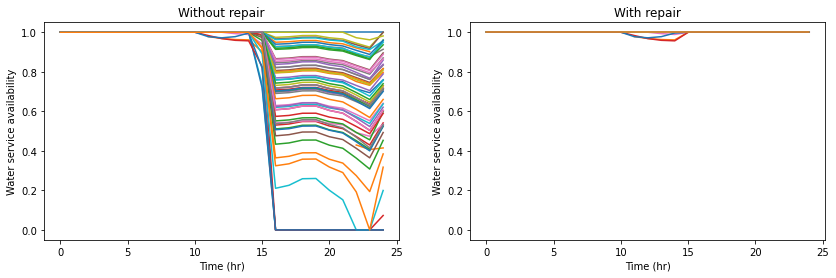

In [13]:
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand'].loc[:,wn.junction_name_list]
demand_wrepair = results_wrepair.node['demand'].loc[:,wn.junction_name_list]
expected_demand.index = expected_demand.index/3600
demand.index = demand.index/3600
demand_wrepair.index = demand_wrepair.index/3600

wsa = wntr.metrics.water_service_availability(expected_demand, demand)
wsa_wrepair = wntr.metrics.water_service_availability(expected_demand, demand_wrepair)

# WSA
fig, axarr = plt.subplots(1,2,figsize=(14,4))
ax = axarr[0]
wsa.plot(ax=ax, legend=False)
ax.set_ylim(ymin=-0.05, ymax=1.05)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Water service availability')
ax.set_title('Without repair')
ax = axarr[1]
wsa_wrepair.plot(ax=ax, legend=False)
ax.set_ylim(ymin=-0.05, ymax=1.05)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Water service availability')
ax.set_title('With repair')

#### Population impacted

Text(0.5, 1.0, 'With repair')

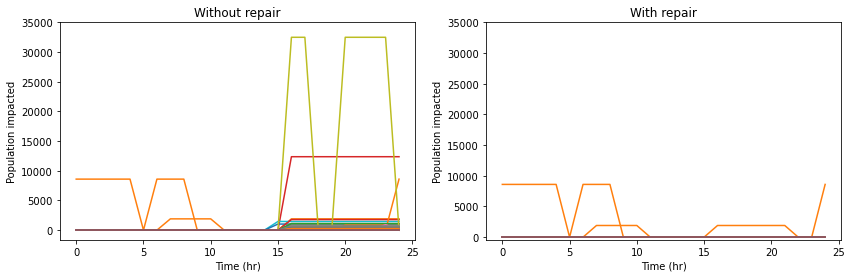

In [14]:
# Note that water service availability of NaN is replaced with 0 for the population impacted calculation
pop = wntr.metrics.population(wn)
pop_impacted = wntr.metrics.population_impacted(pop, wsa.fillna(0), np.less, 0.8)
pop_impacted_wrepair = wntr.metrics.population_impacted(pop, wsa_wrepair.fillna(0), np.less, 0.8)

# Population impacted
fig, axarr = plt.subplots(1,2,figsize=(14,4))
ax = axarr[0]
pop_impacted.plot(ax=ax, legend=False)
ax.set_ylim(ymax=35000)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Population impacted')
ax.set_title('Without repair')
ax = axarr[1]
pop_impacted_wrepair.plot(ax=ax, legend=False)
ax.set_ylim(ymax=35000)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Population impacted')
ax.set_title('With repair')